In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


In [ ]:
import os
import random
import shutil
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [ ]:
train_dir = 'train/simpsons_dataset'
test_dir = 'testset/testset'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
augmentation = transforms.RandomChoice([
            transforms.Compose([
                transforms.Resize(size=300, max_size=301),
                transforms.CenterCrop(size=300),
                transforms.RandomCrop(250)
            ]),
            transforms.RandomRotation(degrees=(-25,25)),
            transforms.RandomHorizontalFlip(p=1)
        ])

In [ ]:
combined_transform = transforms.Compose([
    augmentation,
    transform
])

In [ ]:
train_dataset = ImageFolder(train_dir, transform=combined_transform)

In [ ]:
class_weights = [1 / count for count in torch.bincount(torch.tensor(train_dataset.targets))]
sample_weights = [class_weights[class_idx] for _, class_idx in train_dataset]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)

In [ ]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
num_classes = 42
batch_size = 32
num_epochs = 20

In [ ]:
model = ResNetClassifier(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Використовуємо SGD
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_loss_history = []
f1_score_history = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    true_labels = []
    predicted_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    # Обчислення F1-оцінки
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    f1_score_history.append(f1)

    # Обчислення середнього втрат за епоху
    epoch_loss /= len(train_loader.dataset)
    train_loss_history.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, F1 Score: {f1:.4f}')

Epoch [1/20], Loss: 0.5231, F1 Score: 0.8808
Epoch [2/20], Loss: 0.0875, F1 Score: 0.9787
Epoch [3/20], Loss: 0.0500, F1 Score: 0.9878
Epoch [4/20], Loss: 0.0504, F1 Score: 0.9874
Epoch [5/20], Loss: 0.0371, F1 Score: 0.9913
Epoch [6/20], Loss: 0.0367, F1 Score: 0.9906
Epoch [7/20], Loss: 0.0402, F1 Score: 0.9895
Epoch [8/20], Loss: 0.0224, F1 Score: 0.9946
Epoch [9/20], Loss: 0.0226, F1 Score: 0.9945
Epoch [10/20], Loss: 0.0175, F1 Score: 0.9958
Epoch [11/20], Loss: 0.0156, F1 Score: 0.9960
Epoch [12/20], Loss: 0.0175, F1 Score: 0.9964
Epoch [13/20], Loss: 0.0136, F1 Score: 0.9959
Epoch [14/20], Loss: 0.0195, F1 Score: 0.9948
Epoch [15/20], Loss: 0.0180, F1 Score: 0.9956
Epoch [16/20], Loss: 0.0091, F1 Score: 0.9972
Epoch [17/20], Loss: 0.0079, F1 Score: 0.9978
Epoch [18/20], Loss: 0.0126, F1 Score: 0.9969
Epoch [19/20], Loss: 0.0090, F1 Score: 0.9976
Epoch [20/20], Loss: 0.0121, F1 Score: 0.9969


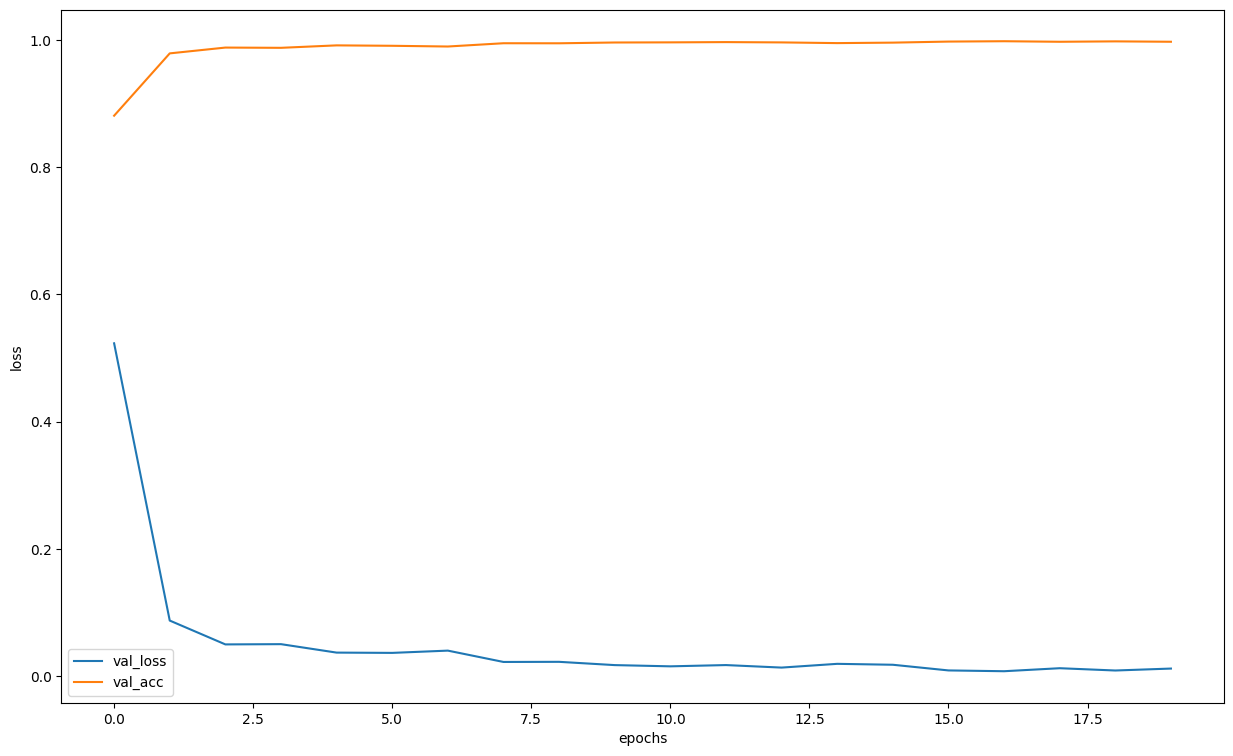

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="val_loss")
plt.plot(f1_score_history, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
test_dir = 'testset/testset'
batch_size = 32

In [ ]:
class TestDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = os.listdir(directory)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

In [ ]:
test_dataset = TestDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def classify_images(model, dataloader):
    model.eval()
    predictions = []
    filenames = []

    with torch.no_grad():
        for images, files in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            filenames.extend(files)

    return predictions, filenames

In [ ]:
predicted_classes, image_filenames = classify_images(model, test_loader)

In [ ]:
class_names = sorted(os.listdir(train_dir))

In [ ]:
import numpy as np

random_indices = np.random.choice(len(test_dataset), 5, replace=False)
random_images = [test_dataset[i][0] for i in random_indices]
random_filenames = [image_filenames[i] for i in random_indices]
random_predicted_classes = [class_names[predicted_classes[i]] for i in random_indices]

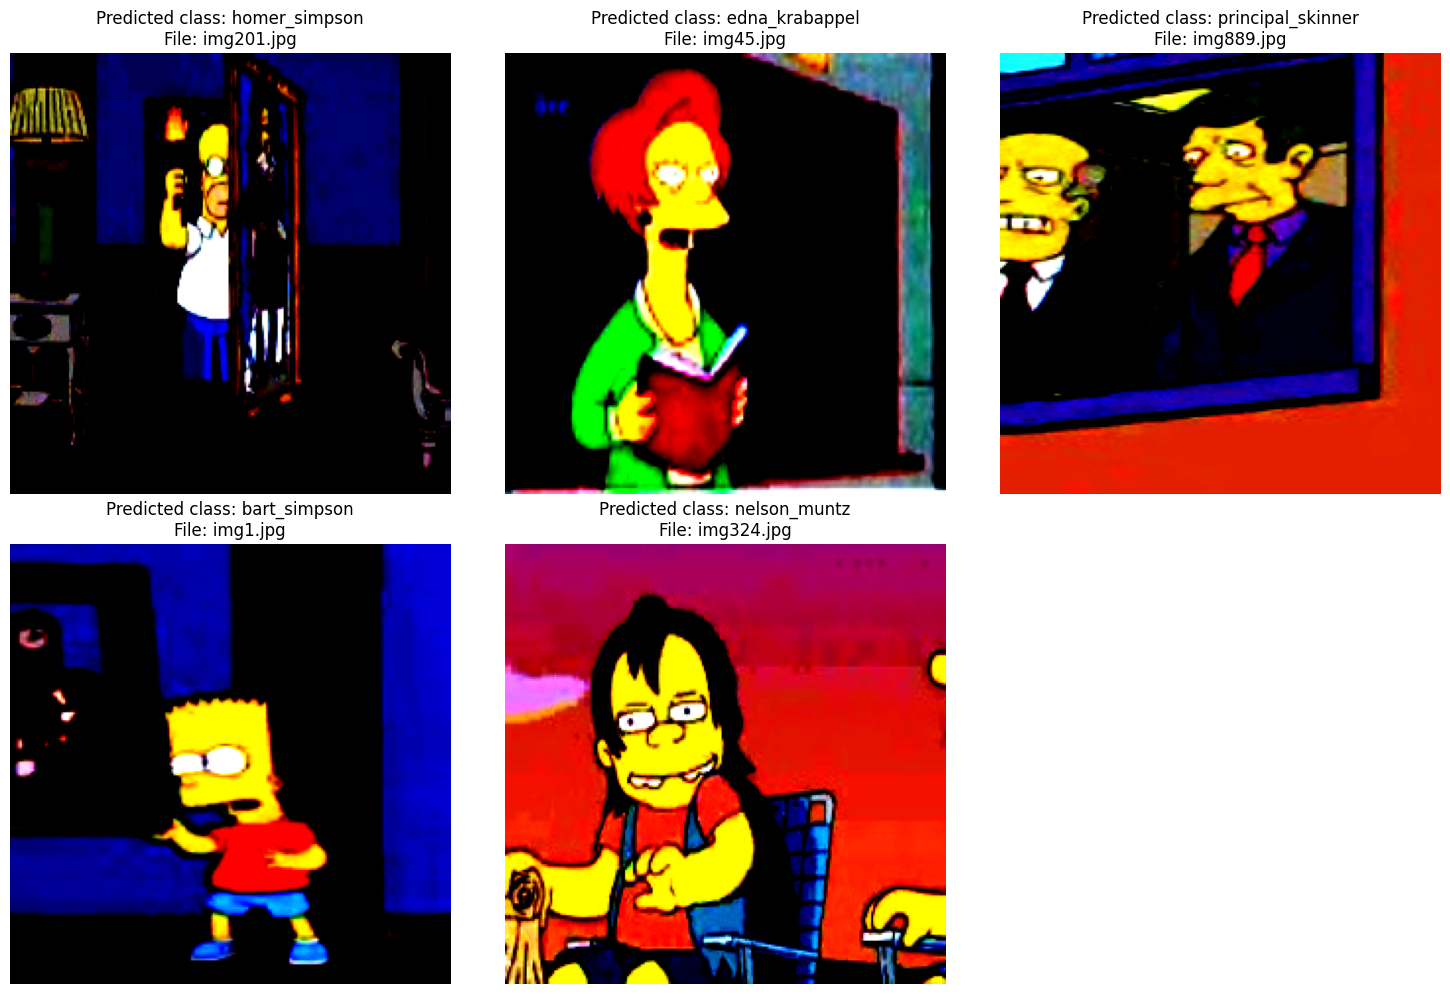

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(random_images[i].permute(1, 2, 0))
    plt.title(f"Predicted class: {random_predicted_classes[i]}\nFile: {random_filenames[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class_names = sorted(os.listdir(train_dir))

In [ ]:
class_names

['abraham_grampa_simpson',
 'agnes_skinner',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'bart_simpson',
 'carl_carlson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'cletus_spuckler',
 'comic_book_guy',
 'disco_stu',
 'edna_krabappel',
 'fat_tony',
 'gil',
 'groundskeeper_willie',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lionel_hutz',
 'lisa_simpson',
 'maggie_simpson',
 'marge_simpson',
 'martin_prince',
 'mayor_quimby',
 'milhouse_van_houten',
 'miss_hoover',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'otto_mann',
 'patty_bouvier',
 'principal_skinner',
 'professor_john_frink',
 'rainier_wolfcastle',
 'ralph_wiggum',
 'selma_bouvier',
 'sideshow_bob',
 'sideshow_mel',
 'snake_jailbird',
 'troy_mcclure',
 'waylon_smithers']

In [ ]:
predictions_df = pd.DataFrame({
    'Id': image_filenames,
    'Expected': [class_names[pred_class] for pred_class in predicted_classes]
})

In [ ]:
predictions_df = predictions_df.sort_values(by='Id')
predictions_df.reset_index(drop=True, inplace=True)
predictions_df.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
output_file = "sample_submission.csv"
predictions_df.to_csv(output_file, index=False)